## Compare Earthquake Transformer

Differences have been observed between Earthquake Transformer from [original implementation](https://github.com/smousavi05/EQTransformer) and from [seisbench](https://github.com/seisbench/seisbench). This notebook investigates what is wrong with the seisbench version.

See [notebooks](https://github.com/zoekrauss/alaska-continuous/blob/main/compare_eqt_seisbench.ipynb) from Zoe Krauss

---
 ##### Yiyu Ni (niyiyu@uw.edu)
 ##### Earth and Space Sciences
 ##### University of Washington

In [1]:
import sys
import numpy as np
import torch
import obspy
from obspy.clients.fdsn import Client
client = Client("iris")
import h5py
sys.path.append("/home/niyiyu/Research/MachineLearning/seisbench/")
import seisbench
import seisbench.models as sbm
import matplotlib.pyplot as plt

In [2]:
# Load model from seisbench
eqt_sbm = sbm.EQTransformer.from_pretrained("original")
eqt_sbm.default_args["blinding"] = (0,0)

# 1. Taper matters
This follows exactually the same process original EqTransformer goes through.

In [3]:
t1 = obspy.UTCDateTime('2019-05-27T00:00:00.000000')
t2 = t1 + 60 * 20
st = client.get_waveforms("XO", "KS11", "--", "HH*", t1, t2)

st.detrend('demean')
st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
st_taped = st.copy().taper(max_percentage=0.001, type='cosine', max_length=2)

In [4]:
sb = eqt_sbm.annotate(st)
sb_taped = eqt_sbm.annotate(st_taped)

st.trim(starttime = t1, endtime = t1 + 60)
st_taped.trim(starttime = t1, endtime = t1 + 60)
sb.trim(starttime = t1, endtime = t1 + 60)
sb_taped.trim(starttime = t1, endtime = t1 + 60)

3 Trace(s) in Stream:
XO.KS11..EQTransformer_Detection | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:00:59.999996Z | 100.0 Hz, 6000 samples
XO.KS11..EQTransformer_P         | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:00:59.999996Z | 100.0 Hz, 6000 samples
XO.KS11..EQTransformer_S         | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:00:59.999996Z | 100.0 Hz, 6000 samples

Text(0.5, 1.0, 'Tapered')

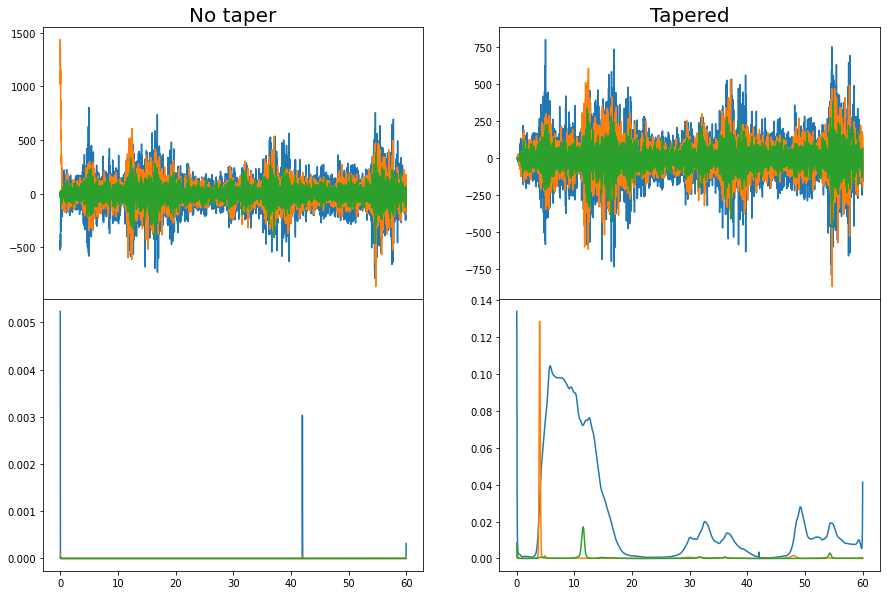

In [5]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0})

for idx, s in enumerate([st, sb]):
    axs[idx, 0].plot(s[0].times(),np.array(s).T) 
axs[0, 0].set_title("No taper", fontsize = 20)

for idx, s in enumerate([st_taped, sb_taped]):
    axs[idx, 1].plot(s[0].times(),np.array(s).T) 
axs[0, 1].set_title("Tapered", fontsize = 20)

# 2. The length of stream does not matter

In [6]:
t1 = obspy.UTCDateTime('2019-05-27T00:00:00.000000')
t2 = t1 + 60 * 20
st = client.get_waveforms("XO", "KS11", "--", "HH*", t1, t2)

st.detrend('demean')
st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
st.taper(max_percentage=0.001, type='cosine', max_length=2)

3 Trace(s) in Stream:
XO.KS11..HHE | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples
XO.KS11..HHN | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples
XO.KS11..HHZ | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples

In [7]:
sb = eqt_sbm.annotate(st)
sb.trim(starttime = t1, endtime = t1 + 60)
st_short = st.trim(starttime = t1, endtime = t1 + 60)
sb_short = eqt_sbm.annotate(st_short)

Text(0.5, 1.0, 'Predict by short stream')

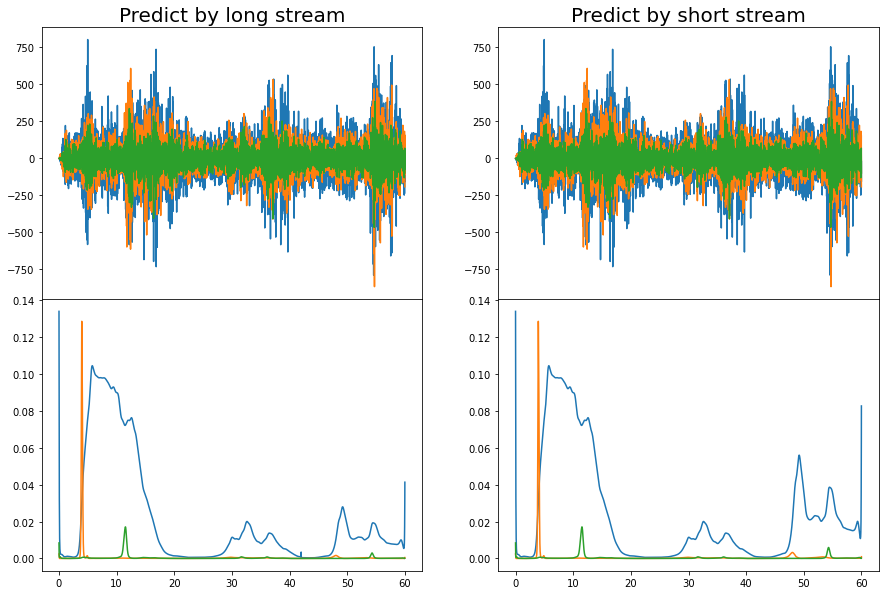

In [8]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 2, gridspec_kw={'hspace': 0})

for idx, s in enumerate([st, sb]):
    axs[idx, 0].plot(s[0].times(),np.array(s).T) 
axs[0, 0].set_title("Predict by long stream", fontsize = 20)

for idx, s in enumerate([st_short, sb_short]):
    axs[idx, 1].plot(s[0].times(),np.array(s).T) 
axs[0, 1].set_title("Predict by short stream", fontsize = 20)

# 3. BUT the order to trim and taper matters

In [9]:
t1 = obspy.UTCDateTime('2019-05-27T00:00:00.000000')
t2 = t1 + 60 * 20
st = client.get_waveforms("XO", "KS11", "--", "HH*", t1, t2)

st.detrend('demean')
st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)

3 Trace(s) in Stream:
XO.KS11..HHE | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples
XO.KS11..HHN | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples
XO.KS11..HHZ | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples

In [10]:
# taper on long stream and then trim
st_taped = st.copy().taper(max_percentage=0.001, type='cosine', max_length=2)
st_taped.trim(starttime = t1, endtime = t1 + 60)
sb = eqt_sbm.annotate(st_taped)

# trim first then taper
st.trim(starttime = t1, endtime = t1 + 60)
st_short = st.taper(max_percentage=0.001, type='cosine', max_length=2)
sb_short = eqt_sbm.annotate(st_short)

Text(0.5, 1.0, 'Taper on short stream')

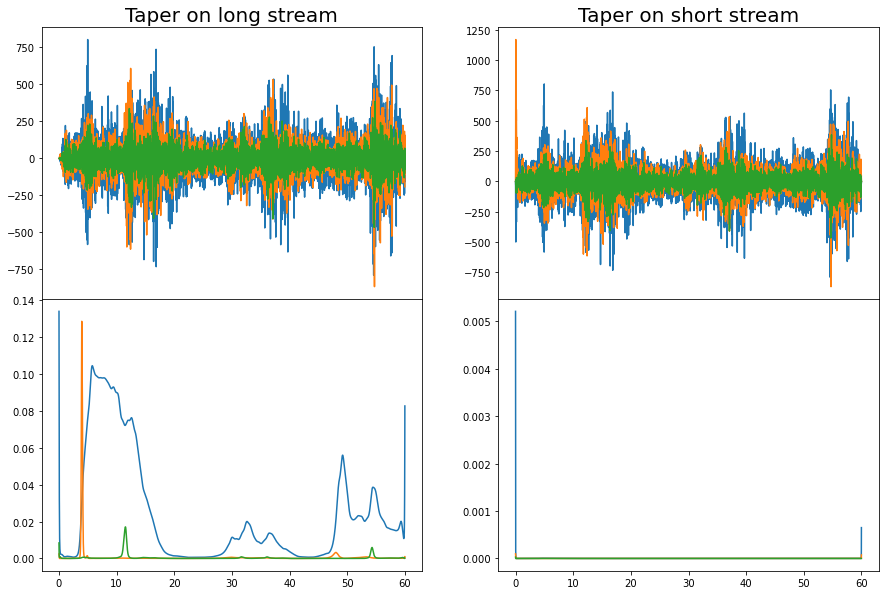

In [11]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 2, gridspec_kw={'hspace': 0})

for idx, s in enumerate([st_taped, sb]):
    axs[idx, 0].plot(s[0].times(),np.array(s).T) 
axs[0, 0].set_title("Taper on long stream", fontsize = 20)

for idx, s in enumerate([st_short, sb_short]):
    axs[idx, 1].plot(s[0].times(),np.array(s).T) 
axs[0, 1].set_title("Taper on short stream", fontsize = 20)

# 4. Filter, especially low frequency component and zero phases matters

In [12]:
t1 = obspy.UTCDateTime('2019-05-27T00:00:00.000000')
t2 = t1 + 60 * 20
st = client.get_waveforms("XO", "KS11", "--", "HH*", t1, t2) 
st.detrend('demean')

3 Trace(s) in Stream:
XO.KS11..HHE | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples
XO.KS11..HHN | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples
XO.KS11..HHZ | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples

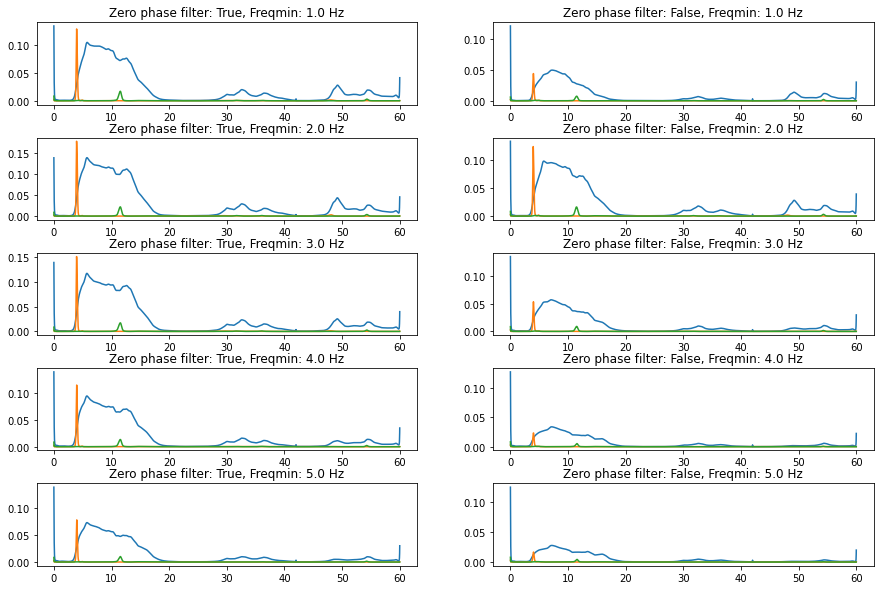

In [13]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(5, 2, gridspec_kw={'hspace': 0.4})
    
for idz, z in enumerate([True, False]):
    for idx, freqmin in enumerate([1., 2., 3., 4., 5.,]):
        st2 = st.copy().filter(type='bandpass', freqmin = freqmin, freqmax = 45, corners=2, zerophase=z)
        st2.taper(max_percentage=0.001, type='cosine', max_length=2)
        sb = eqt_sbm.annotate(st2)
        sb.trim(starttime = t1, endtime = t1 + 60)
        axs[idx, idz].plot(s[0].times(),np.array(sb).T)
        axs[idx, idz].set_title("Zero phase filter: %s, Freqmin: %.1f Hz" % (str(z), freqmin)) 

## It is important to apply zero phase filter, and incorporate more low frequency components. And also note the low prediction values above

## But is it true?

# IMPORTANT: Comparing weights from Seisbench and EqTransformer

- Weights for Seisbench (original.pt) are downloaded from https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/models/eqtransformer/
- Weights from original Earthquake Trnasformer are downloaded from https://github.com/smousavi05/EQTransformer/tree/master/ModelsAndSampleData

## Test show that parameters of Earthquake Transformer are the same between original implementation and seisbench version, EXCEPT FOR the input layer.

## See notebook [here](https://github.com/niyiyu/PNW/blob/main/notebooks/compare_weights.ipynb) for more information

## Swap the first and third channels' weight, and rerun the test.

In [14]:
# swap the first and third channel weight
para_sbm = eqt_sbm.state_dict()
para = np.array(para_sbm['encoder.convs.0.weight'])
para_sbm['encoder.convs.0.weight'] = torch.from_numpy(para[:, ::-1, :].copy())
eqt_sbm.load_state_dict(para_sbm)

<All keys matched successfully>

# 1. Taper still matters

In [15]:
t1 = obspy.UTCDateTime('2019-05-27T00:00:00.000000')
t2 = t1 + 60 * 20
st = client.get_waveforms("XO", "KS11", "--", "HH*", t1, t2)

st.detrend('demean')
st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
st_taped = st.copy().taper(max_percentage=0.001, type='cosine', max_length=2)

In [16]:
sb = eqt_sbm.annotate(st)
sb_taped = eqt_sbm.annotate(st_taped)

st.trim(starttime = t1, endtime = t1 + 60)
st_taped.trim(starttime = t1, endtime = t1 + 60)
sb.trim(starttime = t1, endtime = t1 + 60)
sb_taped.trim(starttime = t1, endtime = t1 + 60)

3 Trace(s) in Stream:
XO.KS11..EQTransformer_Detection | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:00:59.999996Z | 100.0 Hz, 6000 samples
XO.KS11..EQTransformer_P         | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:00:59.999996Z | 100.0 Hz, 6000 samples
XO.KS11..EQTransformer_S         | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:00:59.999996Z | 100.0 Hz, 6000 samples

Text(0.5, 1.0, 'Tapered')

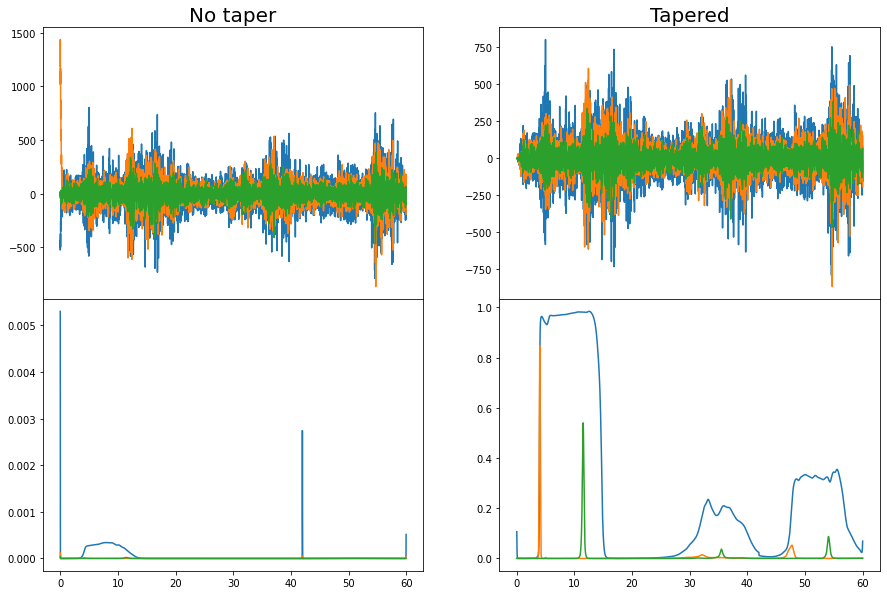

In [17]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0})

for idx, s in enumerate([st, sb]):
    axs[idx, 0].plot(s[0].times(),np.array(s).T) 
axs[0, 0].set_title("No taper", fontsize = 20)

for idx, s in enumerate([st_taped, sb_taped]):
    axs[idx, 1].plot(s[0].times(),np.array(s).T) 
axs[0, 1].set_title("Tapered", fontsize = 20)

# Filter and zero phases DOES NOT matter any more!

In [18]:
t1 = obspy.UTCDateTime('2019-05-27T00:00:00.000000')
t2 = t1 + 60 * 20
st = client.get_waveforms("XO", "KS11", "--", "HH*", t1, t2) 
st.detrend('demean')

3 Trace(s) in Stream:
XO.KS11..HHE | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples
XO.KS11..HHN | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples
XO.KS11..HHZ | 2019-05-27T00:00:00.009996Z - 2019-05-27T00:19:59.999996Z | 100.0 Hz, 120000 samples

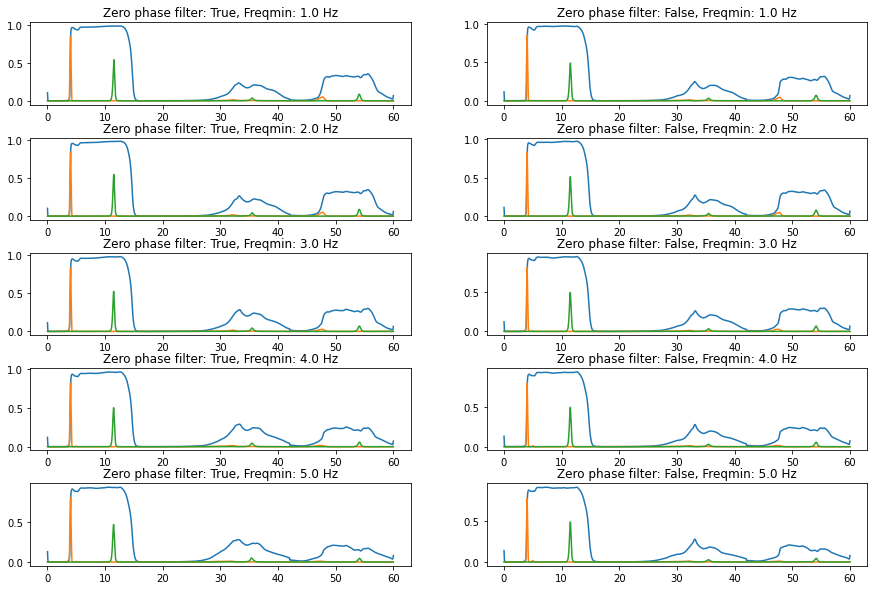

In [19]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(5, 2, gridspec_kw={'hspace': 0.4})
    
for idz, z in enumerate([True, False]):
    for idx, freqmin in enumerate([1., 2., 3., 4., 5.,]):
        st2 = st.copy().filter(type='bandpass', freqmin = freqmin, freqmax = 45, corners=2, zerophase=z)
        st2.taper(max_percentage=0.001, type='cosine', max_length=2)
        sb = eqt_sbm.annotate(st2)
        sb.trim(starttime = t1, endtime = t1 + 60)
        axs[idx, idz].plot(s[0].times(),np.array(sb).T)
        axs[idx, idz].set_title("Zero phase filter: %s, Freqmin: %.1f Hz" % (str(z), freqmin)) 